# EE 445 Final Project (Part 3): Modeling effectiveness of government response
Nicholas Yama, Spring 2020

## Project goal

At the time of writing (07 May 2020) the United States is beginning to see the number of cases slowing, resulting in increase in desire by a vocal minority to return to normal operations. This would involve the uplifing of wide-scale quarantine and stay-at-home orders, of which the evidence indicates has done significant good in slowing the spread of infections. Many arguments are being levied against the effectiveness of these restrictions which are often of dubious scientific merit.

The effectiveness of the government response has varied between states in curbing the number of cases and, due to the lack of national policy from the federal government, will likey be exacerbated as individual states begin to relax these measures. The goal of this project is to model the effectiveness of the government's response at a state level in terms of initial growth rates of the infection.

## Parameters

The number of infected individuals $N$ in its early stages generally can be modeled by an exponential curve

$$N=\exp(r(t-t_0))$$

where $r$ is the growth rate, $t$ is the time, and $t_0$ is the time until the first infection. The growth rate $r$ can then be determined by a linear regression on $\ln(N) = r(t - t_0)$.

This growth rate $r$ will be predicted using a linear regression-type network for the first 6 weeks starting March 1st (a day later the US would reach the first confirmed 100 cases).

The parameters of interest include:
1. The testing rate integrated weekly (so the number of tests administered from March 1 to a given week) normalized by the population (# tests adminstered/population, for 6 weeks).
2. Time from March 1 to declare a "state of emergency"
3. Time from March 1 to issue a stay-at-home order (state level)
4. Maximum number of persons at a gathering (in cases where a distinction is made between private and public gatherings, the maximum is taken)
5. Travel restrictions (1 = none, 2 = partial, 3 = mandatory).
6. School closures (1 = none, 2 = partial, 3 = all).
7. Daycare closures (1 = none, 2 = partial, 3 = all).
8. Restauraunts closures (1 = none, 2 = partial, 3 = all).
8. Non-essential retail closures (1 = none, 2 = partial, 3 = all).
9. Governor political affiliation (-1 = republican, 1 = democrat).
10. Population density (per square mile, control parameter).

When parameters associated with time of response were not achieved within the time frame provided (eg. no stay at home order issued within the 6 weeks) a value of 50 is assigned (greater than maximal value of 42).

Each data point will represent an individual state. Only the 50 states and the District of Columbia will be considered, territories of the US such as American Samoa and Puerto Rico will not be used.

### Data sources
[1] Target data to calculate the growth rate of cases, and the testing data was obtained via the COVID Tracking project: https://covidtracking.com/. The data was collected on May 06 (but data was only used up to April 12 so the collection date does not matter).

[2] Parameters 2-9 were obtained from the Wikipedia page: https://en.wikipedia.org/wiki/U.S._state_and_local_government_response_to_the_COVID-19_pandemic, I processed the data in Microsoft Excel, using a search and replace on terms corresponding to the values above.

[3] Governor partisanship (parameter 9) was found: https://en.wikipedia.org/wiki/List_of_United_States_governors

[4] State population statistics was found from the US 2010 Census projections for 2019. The full dataset can be found: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

# Loading and preprocessing data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load parameters dataset
url = 'https://raw.githubusercontent.com/nyama8/EE-445-Final-Project/master/Processed%20data/sampledata.csv'
datadf = pd.read_csv(url, error_bad_lines=False)
datadf.describe()

,Tests 1,Tests 2,Tests 3,Tests 4,Tests 5,Tests 6,Tests 7,density,emergency,quarantine,gatherings,travel,school,daycares,restauraunts,retail,party
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000,51.000000
mean,0.003220,0.145489,1.380985,8.824113,30.812967,63.724578,102.464746,412.058824,8.921569,29.941176,11.588235,1.862745,3.0,2.764706,2.941176,2.725490,1.490196
std,0.020440,0.454149,3.618019,11.500424,27.779183,54.629108,90.068199,1536.591050,3.632317,9.213928,13.661883,0.916943,0.0,0.586114,0.310597,0.634931,0.543049
min,0.000000,0.000000,0.014126,0.420049,2.752207,6.704623,11.529469,1.000000,-1.000000,18.000000,1.000000,1.000000,3.0,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.006828,0.246191,2.712900,15.046188,37.274537,58.549733,47.500000,7.500000,23.000000,1.000000,1.000000,3.0,3.000000,3.000000,3.000000,1.000000
50%,0.000000,0.047543,0.412394,6.138395,25.719804,49.315151,79.901797,106.000000,10.000000,27.000000,10.000000,2.000000,3.0,3.000000,3.000000,3.000000,2.000000
75%,0.000000,0.121059,1.170444,9.018394,38.097159,69.805266,114.818142,226.500000,12.000000,32.500000,10.000000,3.000000,3.0,3.000000,3.000000,3.000000,2.000000
max,0.145767,3.226572,25.359516,60.308136,170.019023,379.349636,640.796553,11011.000000,15.000000,50.000000,50.000000,3.000000,3.0,3.000000,3.000000,3.000000,2.000000


In [3]:
# Load target dataset
url = 'https://raw.githubusercontent.com/nyama8/EE-445-Final-Project/master/Processed%20data/sampletarget.csv'
targetdf = pd.read_csv(url, error_bad_lines=False)
targetdf.describe()

,rate
count,51.000000
mean,0.216806
std,0.035466
min,0.134223
25%,0.190891
50%,0.219613
75%,0.239307
max,0.299372


In [4]:
data = datadf.to_numpy()
target = targetdf.to_numpy()

# Modeling with a feed-forward network

As an intial pass at this problem, I used linear regression to model the relation between the parameters and infection rate $r$. This would represent a network with 13 input nodes and a single output node with a mean squared error loss function. Here I use a more advanced feed-forward network approach to address the problem.

In the following approaches, I used the tutorial available here: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/, to help with syntax and how to actually implement the network.


## Recreating explicit linear regression with a network
Previously I used the LinearRegression() function which determines the optimal estimator directly. Here I implement a network with the same topology that approximates the same function.

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
# Define the network model
def base_model():
    model = Sequential()
    model.add(Dense(1, input_dim=17, kernel_initializer='normal'))
    
    model.layers[0].set_weights([np.zeros([17,1])+0.01, np.array([0.00])])

    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [7]:
# Generate test and training data splits
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=445)

# Train the network
baseNetwork = base_model()

baseNetwork.fit(X_train, y_train, epochs=150, batch_size=5, shuffle=False)













Epoch 1/150
34/34 [==============================] - 0s 14ms/step - loss: 402.4555
Epoch 2/150
34/34 [==============================] - 0s 260us/step - loss: 158.0172
Epoch 3/150
34/34 [==============================] - 0s 361us/step - loss: 55.3846
Epoch 4/150
34/34 [==============================] - 0s 336us/step - loss: 12.8704
Epoch 5/150
34/34 [==============================] - 0s 298us/step - loss: 2.4755
Epoch 6/150
34/34 [==============================] - 0s 274us/step - loss: 2.6757
Epoch 7/150
34/34 [==============================] - 0s 283us/step - loss: 2.8060
Epoch 8/150
34/34 [==============================] - 0s 273us/step - loss: 1.4979
Epoch 9/150
34/34 [==============================] - 0s 348us/step - loss: 0.3848
Epoch 10/150
34/34 [==============================] - 0s 341us/step - loss: 0.0813
Epoch 11/150
34/34 [==============================] - 0s 294us/step - loss: 0.1203
Epoch 12/150
34/34 [==============================] - 0s 348us/step - loss: 0.1

34/34 [==============================] - 0s 295us/step - loss: 0.0022
Epoch 72/150
34/34 [==============================] - 0s 279us/step - loss: 0.0022
Epoch 73/150
34/34 [==============================] - 0s 282us/step - loss: 0.0022
Epoch 74/150
34/34 [==============================] - 0s 383us/step - loss: 0.0022
Epoch 75/150
34/34 [==============================] - 0s 331us/step - loss: 0.0022
Epoch 76/150
34/34 [==============================] - 0s 241us/step - loss: 0.0021
Epoch 77/150
34/34 [==============================] - 0s 293us/step - loss: 0.0021
Epoch 78/150
34/34 [==============================] - 0s 291us/step - loss: 0.0021
Epoch 79/150
34/34 [==============================] - 0s 254us/step - loss: 0.0021
Epoch 80/150
34/34 [==============================] - 0s 311us/step - loss: 0.0021
Epoch 81/150
34/34 [==============================] - 0s 241us/step - loss: 0.0021
Epoch 82/150
34/34 [==============================] - 0s 320us/step - loss: 0.0020
Epoch 83/150
34/3

In [8]:
test_loss = baseNetwork.evaluate(X_test, y_test, verbose=0)
print('The loss on the testing set:', test_loss)

The loss on the testing set: 0.0032009948045015335


In [9]:
# Compare to exact predictor
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
pred_values = reg.predict(X_train)
mse = np.sqrt( np.mean((pred_values - y_train) ** 2 ) )
print('The loss using sklearn method:', mse)

The loss using sklearn method: 0.015236329999627063


## A single hidden layer
As a first pass at a more complex topology, I will use a network with a single hidden layer smaller than the input data (which is 17 dimensional). The hidden layer will arbitrarily be chosen to be of size 8.

The motivation for this structure is as follows:
1. The initial attempt using linear regression considered all parameters individually. However, the effectiveness of these measures are not independent of each other (eg. high testing rates will not do anything without some quarantine measures). 
2. The hidden layer might be able to capture in essence the idea that the effectiveness is dependent on several features together.
3. The hidden layer could be expected to be smaller than the input since not all combinations are significant there are many combinations of parameters avaialble.

I will use a sigmoid activation function in the hidden layer and again the mean squared error loss function. The sigmoid activation seems to be a decent choice since the hope is that the hidden layer will capture some essence of combinations of the features, so the normalizing effect should help the output neuron be less biased (not really sure if this is a valid argument). Additonally, the data is not too extreme in value and the dataset is relatively small so it shouldn't have too many convergence issues.

As a first attempt, I will use the Adam optimizer because it is popular and I don't quite understand all the parameters available in SGD.

In [10]:
def thin_model():
    model = Sequential()
    model.add(Dense(8, input_dim=17, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Initialize weights
    model.layers[0].set_weights([np.zeros([17,8])+0.01, np.zeros([8,])])
    model.layers[1].set_weights([np.zeros([8,1])+0.01, np.array([0.00])])
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [11]:
thinNetwork = thin_model()



thinNetwork.fit(X_train, y_train, epochs=150, batch_size=5, shuffle=False)

Epoch 1/150
34/34 [==============================] - 1s 19ms/step - loss: 0.0136
Epoch 2/150
34/34 [==============================] - 0s 276us/step - loss: 0.0037
Epoch 3/150
34/34 [==============================] - 0s 291us/step - loss: 0.0011
Epoch 4/150
34/34 [==============================] - 0s 326us/step - loss: 0.0016
Epoch 5/150
34/34 [==============================] - 0s 354us/step - loss: 0.0018
Epoch 6/150
34/34 [==============================] - 0s 344us/step - loss: 0.0014
Epoch 7/150
34/34 [==============================] - 0s 342us/step - loss: 0.0013
Epoch 8/150
34/34 [==============================] - 0s 362us/step - loss: 0.0012
Epoch 9/150
34/34 [==============================] - 0s 343us/step - loss: 0.0012
Epoch 10/150
34/34 [==============================] - 0s 510us/step - loss: 0.0012
Epoch 11/150
34/34 [==============================] - 0s 342us/step - loss: 0.0012
Epoch 12/150
34/34 [==============================] - 0s 400us/step - loss: 0.0012
Epoch 13/150
3

34/34 [==============================] - 0s 338us/step - loss: 7.2293e-04
Epoch 97/150
34/34 [==============================] - 0s 353us/step - loss: 7.2216e-04
Epoch 98/150
34/34 [==============================] - 0s 311us/step - loss: 7.2112e-04
Epoch 99/150
34/34 [==============================] - 0s 313us/step - loss: 7.2044e-04
Epoch 100/150
34/34 [==============================] - 0s 322us/step - loss: 7.1951e-04
Epoch 101/150
34/34 [==============================] - 0s 360us/step - loss: 7.1870e-04
Epoch 102/150
34/34 [==============================] - 0s 333us/step - loss: 7.1788e-04
Epoch 103/150
34/34 [==============================] - 0s 300us/step - loss: 7.1702e-04
Epoch 104/150
34/34 [==============================] - 0s 273us/step - loss: 7.1622e-04
Epoch 105/150
34/34 [==============================] - 0s 300us/step - loss: 7.1539e-04
Epoch 106/150
34/34 [==============================] - 0s 289us/step - loss: 7.1458e-04
Epoch 107/150
34/34 [============================

In [12]:
test_loss = thinNetwork.evaluate(X_test, y_test, verbose=0)
print('The loss on the testing set:', test_loss)

The loss on the testing set: 0.0014621701557189226


Evidently, at least for this particular training and testing set, the single layer thing network did a significantly better job on predicting the output than the base model.

## Two hidden layers
Adding additional complexity, I will add a second hidden layer, also of size 8.

The hope was that the first hidden layer in the previous attempt might capture the essence of "combinations" of the parameters being significant. However, not all combinations are trivial. For instance, high early testing rates might be significant only if quarantine measures are enacted, but quarantine measures could be enacted without high testing rates and still be effective. Additional complexities like this might hopefully be captured by the addition of a second hidden layer.

I will use the same parameters for the second layer as well (at least initially).

In [13]:
def deep_model():
    model = Sequential()
    model.add(Dense(8, input_dim=17, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(8, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
deepNetwork = deep_model()

# Initialize weights
deepNetwork.layers[0].set_weights([np.zeros([17,8])+0.01, np.zeros([8,])])
deepNetwork.layers[1].set_weights([np.zeros([8,8])+0.01, np.zeros([8,])])
deepNetwork.layers[2].set_weights([np.zeros([8,1])+0.01, np.array([0.00])])

deepNetwork.fit(X_train, y_train, epochs=150, batch_size=5, shuffle=False)

Epoch 1/150
34/34 [==============================] - 1s 25ms/step - loss: 0.0262
Epoch 2/150
34/34 [==============================] - 0s 343us/step - loss: 0.0156
Epoch 3/150
34/34 [==============================] - 0s 382us/step - loss: 0.0079
Epoch 4/150
34/34 [==============================] - 0s 373us/step - loss: 0.0033
Epoch 5/150
34/34 [==============================] - 0s 412us/step - loss: 0.0014
Epoch 6/150
34/34 [==============================] - 0s 412us/step - loss: 0.0011
Epoch 7/150
34/34 [==============================] - 0s 402us/step - loss: 0.0013
Epoch 8/150
34/34 [==============================] - 0s 438us/step - loss: 0.0014
Epoch 9/150
34/34 [==============================] - 0s 438us/step - loss: 0.0013
Epoch 10/150
34/34 [==============================] - 0s 442us/step - loss: 0.0012
Epoch 11/150
34/34 [==============================] - 0s 438us/step - loss: 0.0012
Epoch 12/150
34/34 [==============================] - 0s 434us/step - loss: 0.0012
Epoch 13/150
3

34/34 [==============================] - 0s 317us/step - loss: 8.2163e-04
Epoch 97/150
34/34 [==============================] - 0s 369us/step - loss: 8.2142e-04
Epoch 98/150
34/34 [==============================] - 0s 333us/step - loss: 8.2121e-04
Epoch 99/150
34/34 [==============================] - 0s 417us/step - loss: 8.2100e-04
Epoch 100/150
34/34 [==============================] - 0s 392us/step - loss: 8.2080e-04
Epoch 101/150
34/34 [==============================] - 0s 326us/step - loss: 8.2061e-04
Epoch 102/150
34/34 [==============================] - 0s 301us/step - loss: 8.2043e-04
Epoch 103/150
34/34 [==============================] - 0s 389us/step - loss: 8.2024e-04
Epoch 104/150
34/34 [==============================] - 0s 438us/step - loss: 8.2007e-04
Epoch 105/150
34/34 [==============================] - 0s 390us/step - loss: 8.1989e-04
Epoch 106/150
34/34 [==============================] - 0s 314us/step - loss: 8.1973e-04
Epoch 107/150
34/34 [============================

In [15]:
test_loss = deepNetwork.evaluate(X_test, y_test, verbose=0)
print('The loss on the testing set:', test_loss)

The loss on the testing set: 0.0012646723771467805


This time around, the additonal layer did not significantly improve the loss when a signmoid activation function is implemented. Instead trying a RELU activation in the second layer:

In [20]:
def deep_model():
    model = Sequential()
    model.add(Dense(8, input_dim=17, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.layers[0].set_weights([np.zeros([17,8])+0.01, np.zeros([8,])])
    model.layers[1].set_weights([np.zeros([8,8])+0.01, np.zeros([8,])])
    model.layers[2].set_weights([np.zeros([8,1])+0.01, np.array([0.00])])
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

deepNetwork = deep_model()

deepNetwork.fit(X_train, y_train, epochs=150, batch_size=5, shuffle=False)

Epoch 1/150
34/34 [==============================] - 1s 34ms/step - loss: 0.0423
Epoch 2/150
34/34 [==============================] - 0s 450us/step - loss: 0.0336
Epoch 3/150
34/34 [==============================] - 0s 392us/step - loss: 0.0234
Epoch 4/150
34/34 [==============================] - 0s 379us/step - loss: 0.0132
Epoch 5/150
34/34 [==============================] - 0s 368us/step - loss: 0.0053
Epoch 6/150
34/34 [==============================] - 0s 401us/step - loss: 0.0015
Epoch 7/150
34/34 [==============================] - 0s 564us/step - loss: 0.0013
Epoch 8/150
34/34 [==============================] - 0s 359us/step - loss: 0.0018
Epoch 9/150
34/34 [==============================] - 0s 394us/step - loss: 0.0016
Epoch 10/150
34/34 [==============================] - 0s 393us/step - loss: 0.0013
Epoch 11/150
34/34 [==============================] - 0s 407us/step - loss: 0.0013
Epoch 12/150
34/34 [==============================] - 0s 399us/step - loss: 0.0012
Epoch 13/150
3

34/34 [==============================] - 0s 429us/step - loss: 7.3075e-04
Epoch 97/150
34/34 [==============================] - 0s 408us/step - loss: 7.2970e-04
Epoch 98/150
34/34 [==============================] - 0s 430us/step - loss: 7.2866e-04
Epoch 99/150
34/34 [==============================] - 0s 372us/step - loss: 7.2762e-04
Epoch 100/150
34/34 [==============================] - 0s 420us/step - loss: 7.2658e-04
Epoch 101/150
34/34 [==============================] - 0s 471us/step - loss: 7.2554e-04
Epoch 102/150
34/34 [==============================] - 0s 418us/step - loss: 7.2451e-04
Epoch 103/150
34/34 [==============================] - 0s 401us/step - loss: 7.2347e-04
Epoch 104/150
34/34 [==============================] - 0s 385us/step - loss: 7.2246e-04
Epoch 105/150
34/34 [==============================] - 0s 353us/step - loss: 7.2142e-04
Epoch 106/150
34/34 [==============================] - 0s 380us/step - loss: 7.2040e-04
Epoch 107/150
34/34 [============================

In [19]:
test_loss = deepNetwork.evaluate(X_test, y_test, verbose=0)
print('The loss on the testing set:', test_loss)

The loss on the testing set: 0.001011198852211237


Interestingly, the RELU loss function seems to improve the loss ever so slightly more... Perhaps this is due to the fact that the first layer can pick out the significant combinations (normalized) and the second can evaluate the relative significance between them. Regardless, the improvement is not that significant.

# Comparison of performance

In [23]:
# This will take a long time to run
reg_mse = []
base_mse = []
thin_mse = []
deep_mse = []
trivial_mse = []
for i in range(10):
    print('Starting test set number', i)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33)
    reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)

    pred_values = reg.predict(X_train)
    
    print('Training base network...')
    baseNetwork = base_model()
    baseNetwork.fit(X_train, y_train, epochs=100, batch_size=5, shuffle=False, verbose=0)
    base_loss = baseNetwork.evaluate(X_test, y_test, verbose=0)
    
    print('Training thin network...')
    thinNetwork = thin_model()
    thinNetwork.fit(X_train, y_train, epochs=100, batch_size=5, shuffle=False, verbose=0)
    thin_loss = thinNetwork.evaluate(X_test, y_test, verbose=0)
    
    print('Training deep network...')
    deepNetwork = deep_model()
    deepNetwork.fit(X_train, y_train, epochs=100, batch_size=5, shuffle=False, verbose=0)
    deep_loss = deepNetwork.evaluate(X_test, y_test, verbose=0)
    
    
    reg_mse = np.append(reg_mse, np.sqrt( np.mean((pred_values - y_train) ** 2 ) ))
    base_mse = np.append(base_mse, base_loss)
    thin_mse = np.append(thin_mse, thin_loss)
    deep_mse = np.append(deep_mse, deep_loss)
    trivial_mse = np.append(trivial_mse, np.sqrt( np.mean( (np.mean(y_train) - y_test)**2 ) ))

Starting test set number 0
Training base network...
Training thin network...
Training deep network...
Starting test set number 1
Training base network...
Training thin network...
Training deep network...
Starting test set number 2
Training base network...
Training thin network...
Training deep network...
Starting test set number 3
Training base network...
Training thin network...
Training deep network...
Starting test set number 4
Training base network...
Training thin network...
Training deep network...
Starting test set number 5
Training base network...
Training thin network...
Training deep network...
Starting test set number 6
Training base network...
Training thin network...
Training deep network...
Starting test set number 7
Training base network...
Training thin network...
Training deep network...
Starting test set number 8
Training base network...
Training thin network...
Training deep network...
Starting test set number 9
Training base network...
Training thin network...
Train

In [43]:
error = np.stack([reg_mse, trivial_mse, base_mse, thin_mse, deep_mse])

errdf = pd.DataFrame(error.T, columns=['LinReg', 'Trivial', 'Base', 'Thin', 'Deep'])
errdf.describe()

,LinReg,Trivial,Base,Thin,Deep
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.017971,0.038345,0.030671,0.001445,0.001230
std,0.002156,0.004628,0.043885,0.000475,0.000420
min,0.014355,0.029122,0.002078,0.000667,0.000764
25%,0.016765,0.036728,0.004562,0.001109,0.000909
50%,0.017549,0.038345,0.006746,0.001581,0.001096
75%,0.019332,0.041675,0.040481,0.001747,0.001556
max,0.021058,0.044101,0.139833,0.002067,0.001942


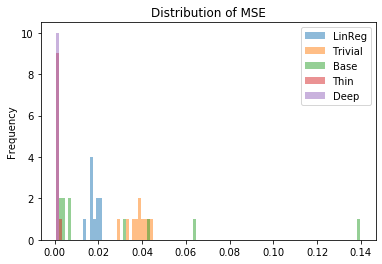

In [46]:
ax = errdf.plot.hist(bins=100, alpha=0.5, title='Distribution of MSE')